# “Learning about Machine Learning with CRIM”


**Abstract**

In this tutorial-essay I will consider how we can use machine learning, speciﬁcally dimensionality reduction and embedding methods, with the CRIM corpus. The guiding question is how style can be modeled quantitatively. Building both on music-theoretical conceptualization and machine learning techniques, it will be demonstrated that unsupervised clustering can serve to some degree as a proxy for stylistic similarity. The CRIM data set provides an ideal case study that will also point to some shortcomings of the computational methodology that can only be resolved by a critical view, drawing on musicological expertise and close-reading of sources.


## 1 Introduction

Much of corpus-based music research addresses questions of style. Be it a composer's particular idiom (Meyer, 1989), 
stylistic characteristics under a diachronic perspective (Harasim et al., 2020), or the question of how likely we can uncover the identidy of a work's author if it is unknown (Brinkmann et al., 2014). These and similar questions are paramount in digital humanities research and often subsumed under the notion of "stylometry". 
Viewed abstractly, style can be simply conceptualized as degrees of similarity: artists or work sharing the same style should be more similar to one another than to an artist or work from a different style. Of course, a composer can also compose in different styles, but then one would expect that pieces in the same style are, in some sense, more similar to each other than to the remaining body of work. This view naturally extends to historical and cross-cultural similarities, but these are out of the present scope.

The central question to determine stylistic similarity is, then, the question of how one conceives of "similarities" between things. 
In the research literature, different approaches have been taken to define musical (dis-)similarity, but the important takeaway from prior research is that the answer to the question "What is musical similarity?" is "It depends!". How one defines similarities is largely dependent on one's research interest, and no single definition will satisfy all purposes. It is here where it becomes apparent that computational approaches always require some form of domain knowledge or expertise, without which wrong assumptions could be hard-coded and produce unreliable or simply wrong results.

The goal of the present essay is to exemplify a machine-learning workflow using the CRIM dataset. To that end, the notion of similarity used here will be rather simple: we will compare pieces in terms of which notes (and how many of them) they contain. While somewhat simplistic, this notion allows us to conceptualize the entire corpus in an abstract space given by this similarity, where we can subsequently apply two fundamentyl data science techniques: dimensionality reduction and clustering. The focus will mainly lie on the conceptual understanding and not on their algorithmic intricacies in order to demonstrate _what kind_ of research they enable. This motivates also my choice for a rather informal tutorial-style language that is meant to facilitate working through the code examples and to potentially adapt or expand them.

The main concepts introduced here are:
* Regular Expressions
* Vector-space model
* Line of fifths
* Dimensionality reduction
* Clustering

## 2 Preparations

Not all data are equal. And most of the time, data is not in the form immediately usable for research. Fortunately, the CRIM intervals library provides a range of functionalities to quickly obtain and modify the encoded scores for further processing.

### 2.1 Obtaining the data

The first step is to install the CRIM intervals library to use its functions. But we will also need several other libraries to perform our analyses.
The code block below summarizes everything that is needed and briefly states what each part will be used for. If you are not interested in reproducing these results, feel free to skip over this section.

In [14]:
# Uncomment the following line to install CRIM intervals
# %pip install --upgrade --force-reinstall git+https://github.com/HCDigitalScholarship/intervals.git@main 

ABS_PATH = "./" # path to the working directory, adapt to a different one if necessary

import os, glob # for reading files
from tqdm import tqdm # show status bar for loops
import re # use regular expressions
import requests # to download files

import numpy as np # for numerical operations
import pandas as pd # to work with tabular data
import intervals as ci # crim intervals
from collections import Counter # to count things

from sklearn.decomposition import PCA # for dimensionality reduction with principal components analysis
from sklearn.cluster import KMeans # for clustering with the K-means algorithm

# the code below imports libraries for data visualization and sets the layout of the figures
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
import seaborn as sns
sns.set_context("notebook")
w = 10
figsize = (w, w/1.333)

# for score rendering
import verovio
from IPython.core.display import HTML

We now access the CRIM corpus and store it in our working directory, so that we have to download it only once.
First we get a list of the URLs pointing to each piece in the corpus following the instructions [here](https://github.com/RichardFreedman/CRIM_JHUB/blob/main/Make-me-a-Corpus.ipynb) and [here](https://github.com/RichardFreedman/CRIM_JHUB/blob/main/CRIM_04b_Cadences_Corpus.ipynb).

In [2]:
raw_prefix = "https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/"
URL = "https://api.github.com/repos/CRIM-Project/CRIM-online/git/trees/990f5eb3ff1e9623711514d6609da4076257816c"
piece_json = requests.get(URL).json()
piece_list = [raw_prefix + p["path"] for p in piece_json["tree"]]

The variable `piece_list` now contains all URLs and names of files in the CRIM corpus. We can now, for instance inspect the first 5 items and see that they each point to a different score in MEI format.

In [3]:
piece_list[:5]

['https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001.mei',
 'https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001_1.mei',
 'https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001_2.mei',
 'https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001_3.mei',
 'https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001_4.mei']

In total, we have `len(piece_list)` pieces: 

In [4]:
len(piece_list)

307

There are 307 files in total. Downloading the files takes a certain amount of time. To speed this up, we save all files in the `piece_list` variable to our local directory. First, we create a new directory `data/` but only if it does not already exist. Likewise for the `img/` directory in which we will store the figures later.

In [5]:
d = "data/"
if not os.path.exists(d):
    os.makedirs(d)
    
img = "img/"
if not os.path.exists(img):
    os.makedirs(img)

Next, we iterate over `piece_list`, request the file from the server, and save it to that directory. The [tqdm](https://tqdm.github.io/) part of the code produces a nice visualization of the iteration.

In [6]:
for piece in tqdm(piece_list):
    filename = piece.split("/")[-1] # only the part after the last '/' is the filename    
    if not os.path.isfile(d + filename):
        with open(d + filename, "w") as f:
            r = requests.get(piece)
            f.write(r.text)

100%|█████████████████████████████████████| 307/307 [00:00<00:00, 136072.21it/s]


We create a new list named `local_files` containing all local file paths and names instead of URLs pointing to a server.

In [7]:
local_files = glob.glob("data/*.mei")

Now we have a variable `local_files` that contains a list of file names pointing to MEI files in our local `data/` directory. At a closer look you'll see that some of them end in something like `0001_1.mei` but a few others end in `0001.mei` (without an underscore). There is a pattern to this. The files without the trailing digit are 'wrappers' that bind all movements (indexed 1 through 9) of a particular mass (indexed 0001 through 9999) together. Since these wrappers do not contain any notes or cadences (those are stored in the MEI files of the respective movements), we'll filter them out. 

Fortunately, this is very easy since the CRIM team has assigned filenames in a very systematic way. We only need to remove all files from the `local_files` list that have a file name ending in `_d.mei`, where `d` stands for any single-digit integer.

In [8]:
local_files = [ f  for f in local_files if re.match(r".+_\d.mei$", f) ]

What happened here? We defined a pattern according to which we were able to remove the wrapper file names. This pattern is here expressed as a **regular expression**: `r".+_\d.mei$"`
Let's take it apart to understand how it works.

As you probably now, strings in Python are surrounded by either one or two quotation marks (`'` or `"`). The `r` prefixed to the expression tells the interpreter that the string enclosed in quotes is a regular expression and that the characters have to be interpreted accordingly. 
Next, we see a period `.`. This symbol stands for "any character" in a regular expression. The following `+` means "one or more", so that the combination `.+` stands for a sequence of any characters of length at least 1. With this, we capture the part of the filename preceding the underscore `_`. 
Since the pattern differs towards the end of the file names, we can also view it from the end: The `$` sign marks the end of the string, so that everything to its left has to come just before. Since we are dealing with MEI files, each file name ends with `.mei`, which is exactly what we see before the `$`. 
Now the crucial part. The 'wrapper' files do not have an underscore followed by a single-digit integer. We can use this information and represent that integer with `\d`. 
You can test matching text with regular expressions here: https://regexr.com/ 

Consequently, filenames **not** following this pattern (not being captured by the regular expression) will not be taken into account. In English, we could read the list comprehension for `local_files` as: "make a list of filenames where each filename conforms to the pattern defined by the regular expression".
These are the 5 first movements in the list:

In [9]:
local_files[:5]

['data/CRIM_Mass_0031_4.mei',
 'data/CRIM_Mass_0030_3.mei',
 'data/CRIM_Mass_0030_2.mei',
 'data/CRIM_Mass_0009_5.mei',
 'data/CRIM_Mass_0019_5.mei']

As it turns out, they are not in lexicographical order. This can be easily fixed with the following line of code.

In [10]:
local_files = sorted(local_files)

In [13]:
local_files[:5]

['data/CRIM_Mass_0001_1.mei',
 'data/CRIM_Mass_0001_2.mei',
 'data/CRIM_Mass_0001_3.mei',
 'data/CRIM_Mass_0001_4.mei',
 'data/CRIM_Mass_0001_5.mei']

In [11]:
len(local_files)

220

After removing the "wrapper" files, there are "only" 220 individual mass movements left. Still a quite large resource to work with!

### 2.2 Transforming the data

Now that we have all files stored in our local directory, it is finally time to access them, and transform them from the complex MEI encoding into a simplar tabular format that suffices for the kind of analyses we will perform. The CRIM intervals library (imported as `ci`, see above) provides a convenient way to do so: we create a `corpus` variable by passing a list of files to the `CorpusBase` object. Be aware, however, that while this is a convenient way to to this, it might be quite slow because 200 files are parsed.

**Unfortunately, this procedure does not seem to work for CRIM_MASS_0004_3.mei, so we remove it from the list.**

In [12]:
print(local_files[17])
del local_files[17] # contains encoding errors?

data/CRIM_Mass_0004_3.mei


In [15]:
%%capture
# The line above prevents the output of this cell being printed

corpus = ci.CorpusBase([ABS_PATH + f for f in local_files]) # this takes a while...

## Pitch-class counts

As mentioned in the introduction above, to illustrate the machine-learning techniques dimensionality reduction and clustering, we will transform the data in the CRIM corpus to a simple representation that only accounts for the number of occurrences of notes in the pieces. More specifically, we will also disregard octave differences, thus treating all voices and registers equally. We will, however _not_ assume enharmonic equivalence (e.g. F$\sharp$ = G$\flat$), which would be historically inappropriate for Renaissance music. We thus have more than just twelve pitch-classes, actually potentially infinitely many. Tones in this representation, pitches plus octave but not octave equivalence, is sometimes called "tonal pitch classes" (Temperley, 2000; Moss & Rohrmeier, 2020). In the present context, we will drop the attribute "tonal".

The next thing to do is to go through all the pieces in our corpus and actually count the pitch classes. In the following code cell, we first initialize two empty lists `counters` and `finals`. The first one will store the pitch-class counts for each piece, using a `Counter`. The second list stores the finals of each piece.

In [30]:
counters = [] # collects the note counts for each piece
finals = [] # collects the lowest note at the end of each piece

for score in tqdm(corpus.scores):
    c = Counter()
    # finals.append(score.lowLine().iloc[-1][:-1])
    finals.append(score.final()[:-1]) # omit the last character that indicates the octave
    for n in score.analyses["note_list"]:
#         if n.note.name == "B#":
#             print(score.path)
#             print(n.note.name)
        c[n.note.name] += n.note.duration.quarterLength
    counters.append(c)

100%|████████████████████████████████████████| 219/219 [00:00<00:00, 324.40it/s]


---

---

---

In [32]:
pd.Series(finals).value_counts()

G     121
D      35
A      21
F      15
C      12
E      10
B       3
F#      2
dtype: int64

Some things to note here already: Some of these are extremely unlikely to be real finals, e.g. B or F#.

In [33]:
note_counts = pd.DataFrame(counters)
note_counts.head()

,G,F,A,B-,C,D,F#,rest,E,C#,B,E-,G#,A-,D-,D#,A#,F-,B#
0,253.5,81.5,110.5,85.0,55.0,234.5,6.0,90.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,506.0,300.5,292.0,264.0,168.0,564.5,18.0,382.0,136.0,18.5,0.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,575.0,492.0,461.0,432.0,311.0,792.5,22.5,818.0,194.0,32.0,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,548.5,283.5,313.0,256.5,187.5,588.5,16.0,634.0,205.5,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,198.0,96.0,99.0,106.0,70.0,236.0,6.0,166.0,58.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
lof = [ n + acc for acc in ["-", "", "#"] for n in list("FCGDAEB") ] # line of fifths

# complete columns
for l in lof:
    if l not in note_counts.columns:
        note_counts[l] = 0.

smoothing = 1.
note_counts = note_counts[lof].fillna(0.) # sort tpcs and drop rests; fill NaNs with zeroes
note_counts += 1. # add 1 to each value (smoothing)
note_counts.head()

,F-,C-,G-,D-,A-,E-,B-,F,C,G,...,A,E,B,F#,C#,G#,D#,A#,E#,B#
0,1.0,1.0,1.0,1.0,1.0,1.0,86.0,82.5,56.0,254.5,...,111.5,49.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,5.0,265.0,301.5,169.0,507.0,...,293.0,137.0,1.5,19.0,19.5,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,30.0,433.0,493.0,312.0,576.0,...,462.0,195.0,1.0,23.5,33.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,257.5,284.5,188.5,549.5,...,314.0,206.5,1.0,17.0,27.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,107.0,97.0,71.0,199.0,...,100.0,59.0,1.0,7.0,9.0,1.0,1.0,1.0,1.0,1.0


In [35]:
note_counts.to_csv("note_counts.csv", index=False)

In [36]:
note_counts = pd.read_csv("note_counts.csv")
note_counts.head()

,F-,C-,G-,D-,A-,E-,B-,F,C,G,...,A,E,B,F#,C#,G#,D#,A#,E#,B#
0,1.0,1.0,1.0,1.0,1.0,1.0,86.0,82.5,56.0,254.5,...,111.5,49.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,5.0,265.0,301.5,169.0,507.0,...,293.0,137.0,1.5,19.0,19.5,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,30.0,433.0,493.0,312.0,576.0,...,462.0,195.0,1.0,23.5,33.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,257.5,284.5,188.5,549.5,...,314.0,206.5,1.0,17.0,27.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,107.0,97.0,71.0,199.0,...,100.0,59.0,1.0,7.0,9.0,1.0,1.0,1.0,1.0,1.0


In [37]:
note_counts.sum(axis=0)

F-       221.000000
C-       219.000000
G-       219.000000
D-       261.000000
A-       288.000000
E-      6439.166667
B-     42754.500000
F      73773.666667
C      93828.500000
G     132347.083333
D     135405.083333
A     106021.916667
E      69290.583333
B      32418.166667
F#      8228.500000
C#      4578.000000
G#      1706.000000
D#       223.000000
A#       221.000000
E#       219.000000
B#       228.000000
dtype: float64

In [38]:
pd.Series(finals).to_csv("finals.csv", index=False, header=False)

In [39]:
finals = pd.read_csv("finals.csv", header=None)
finals = finals[0]
finals

0      G
1      G
2      G
3      D
4      G
      ..
214    G
215    G
216    G
217    D
218    D
Name: 0, Length: 219, dtype: object

### 2.3 Term frequencies

In [40]:
cmap = plt.get_cmap('Dark2') # "tab10"
colors = cmap(np.linspace(0, 1, len(lof)))

clrs = [ colors[lof.index(l)] for l in note_counts.idxmax(axis=1)]
clrs = [
    "red" if l == "A"
    else "green" if l == "E" 
    else "black" if l == "G" 
    else "yellow" if l == "D" 
    else "purple" if l == "F" 
    else "blue" if  l == "C"     
    else "" for l in note_counts.idxmax(axis=1) ]

In [41]:
# clrs = [ colors[lof.index(l) ] if not l=="Res" else (0,0,0,0) for l in finals ]

## 3 Dimensionality reduction

TEXT

We start of with our data in $\text

### 3.1 Principal Components Analysis (PCA)

21 dimensions to 2

In [42]:
def plot_raw(data, dim1=None, dim2=None):

    plt.scatter(data[:, dim1], data[:,dim2])

In [43]:
X = note_counts.values

In [44]:
X

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

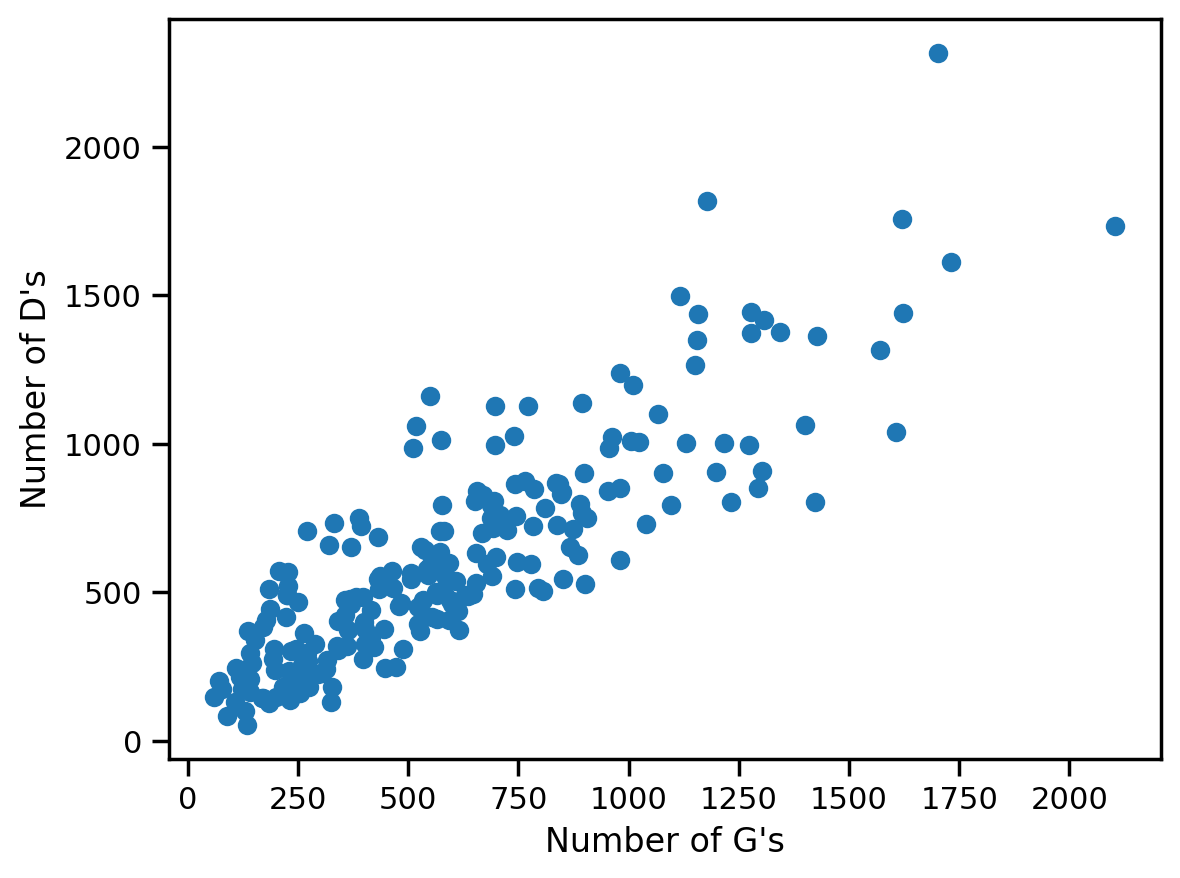

In [45]:
dim1 = 9 # 9
dim2 = 10 # 15

plot_raw(note_counts.values, dim1, dim2)
plt.xlabel(f"Number of {lof[dim1]}'s")
plt.ylabel(f"Number of {lof[dim2]}'s")

plt.show()

In [46]:
from sklearn.decomposition import FastICA

In [47]:
pca_reducer = PCA()

In [48]:
pca_reducer.fit(X)
X_ = pca_reducer.transform(X)

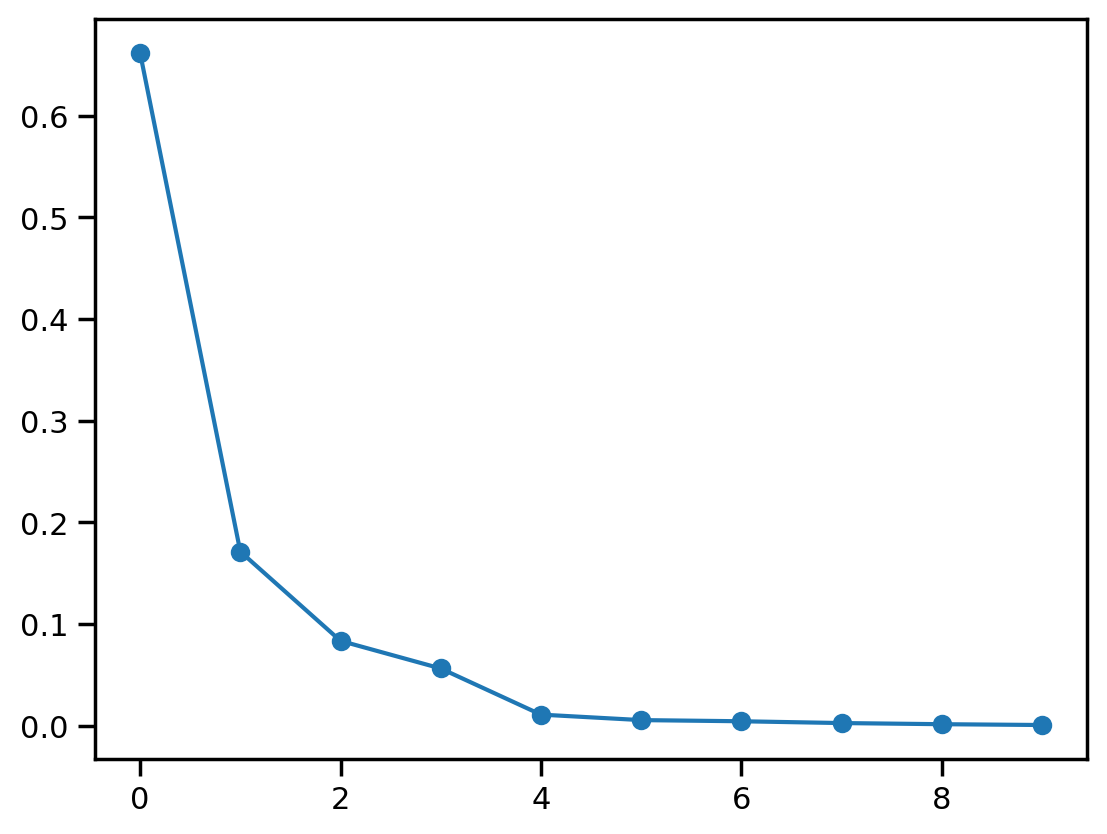

In [49]:
plt.plot(pca_reducer.explained_variance_ratio_[:10], marker="o");

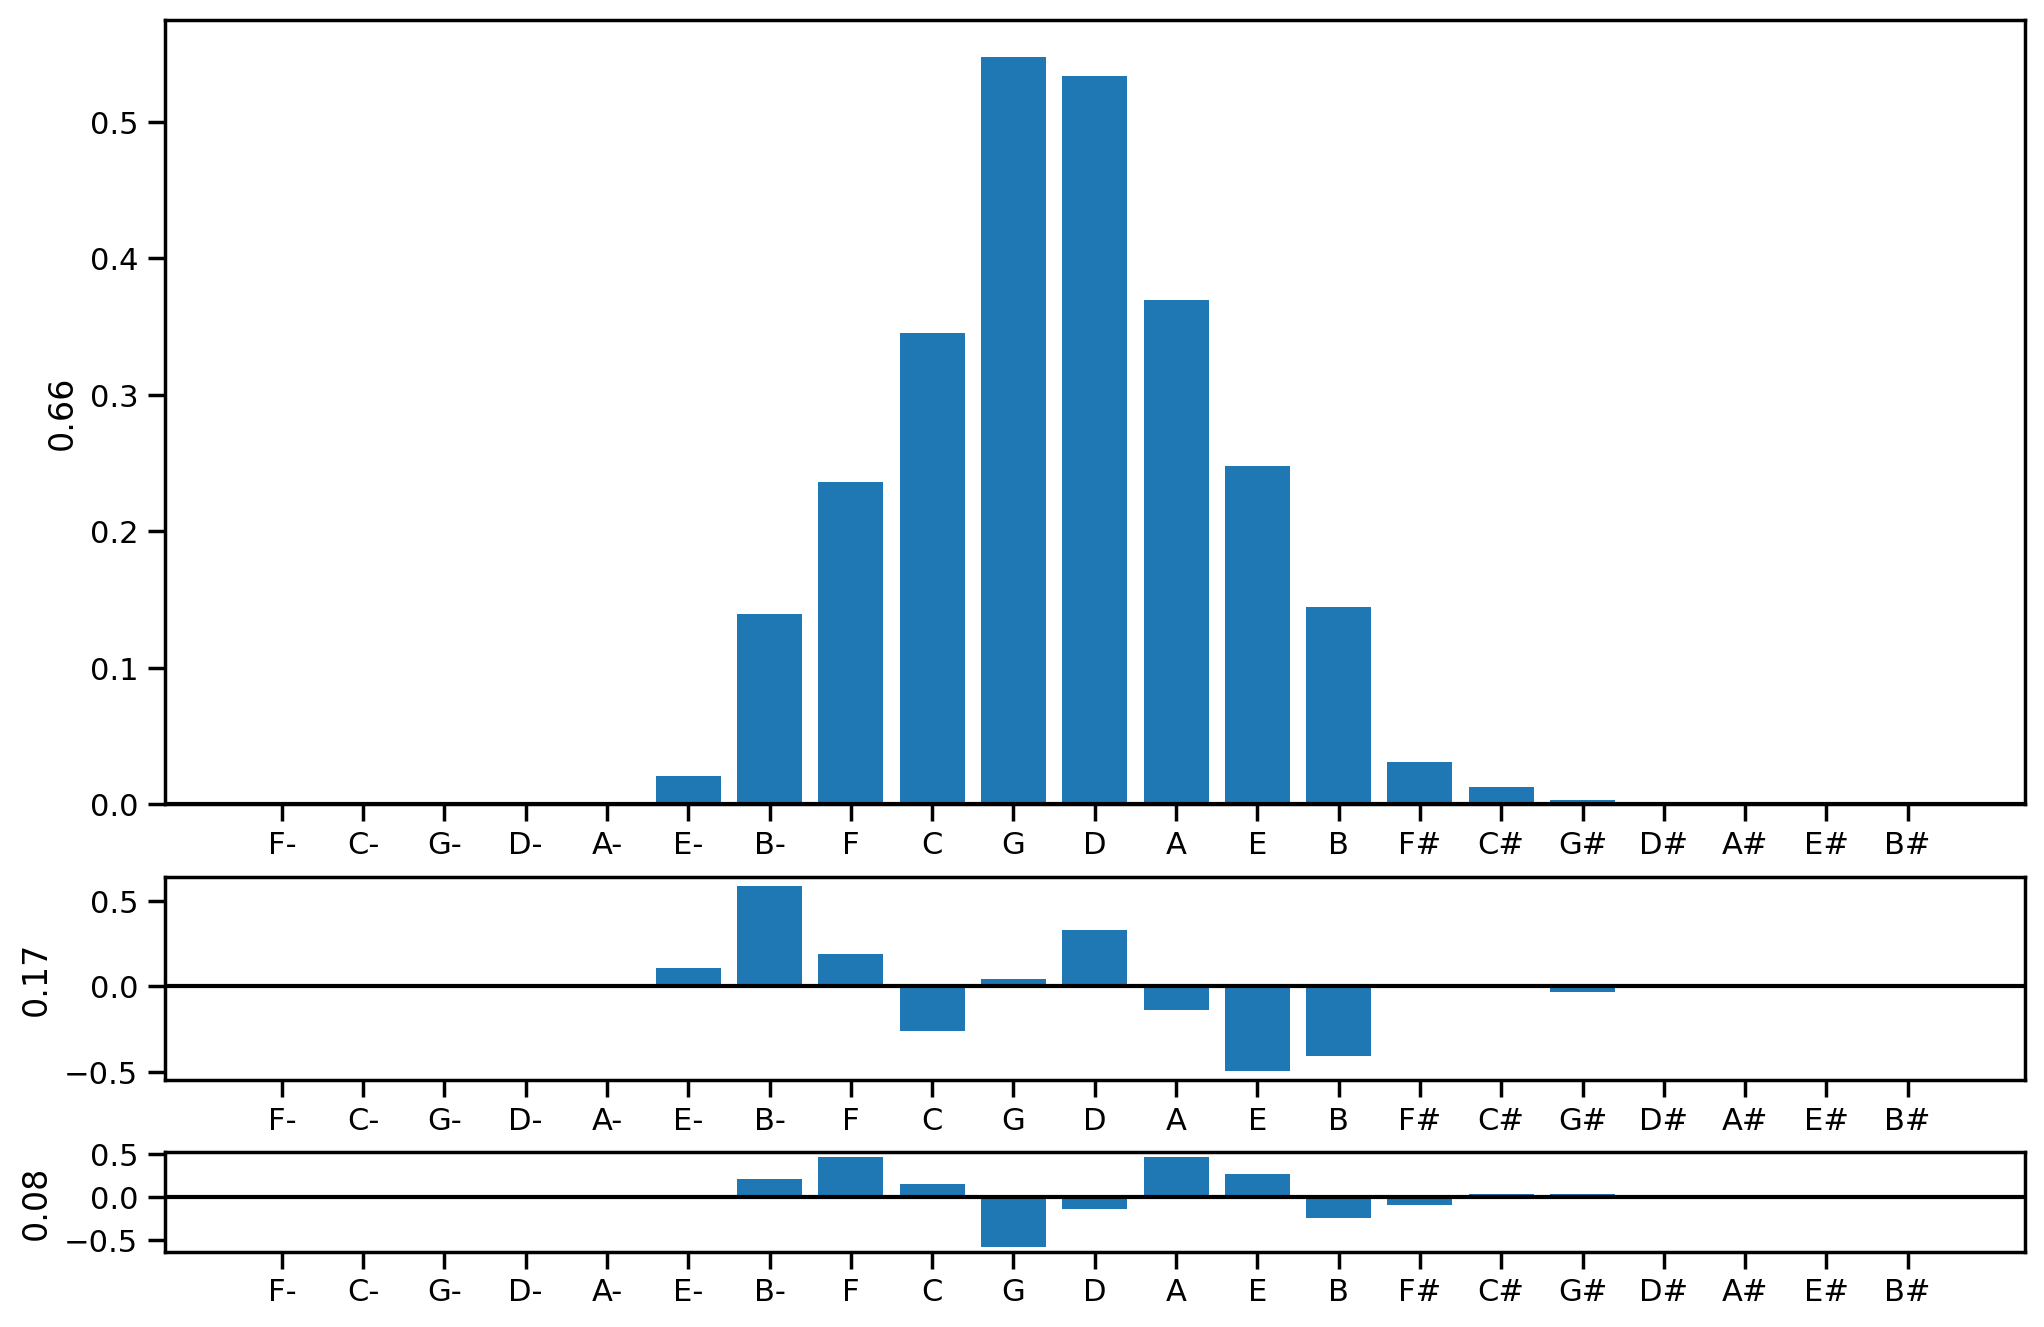

In [50]:
N = pca_reducer.components_.shape[0]
N = 3

fig, axes = plt.subplots(N,1, sharex=False, figsize=(12,8), gridspec_kw={'height_ratios': pca_reducer.explained_variance_ratio_[:N]})

for n in range(N):
    axes[n].axhline(0, c="black")
    axes[n].bar(range(len(lof)), pca_reducer.components_[n])
    axes[n].set_xticks(range(len(lof)), lof)
    
    var = pca_reducer.explained_variance_ratio_[n]
    axes[n].set_ylabel(round(var,2))
plt.show()

In [51]:
def plot_embedding(emb, axes=True, c=None, cmap=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('equal')
    ax.scatter(emb[:,0], emb[:,1], alpha=1., zorder=3, c=c, cmap=cmap)
    for (x, y), s in zip(emb, note_counts.index):
        ax.text(x, y, s, fontsize=10)
    if axes:
        ax.axhline(0, lw=.5, c="k")
        ax.axvline(0, lw=.5, c="k")
    # plt.show()

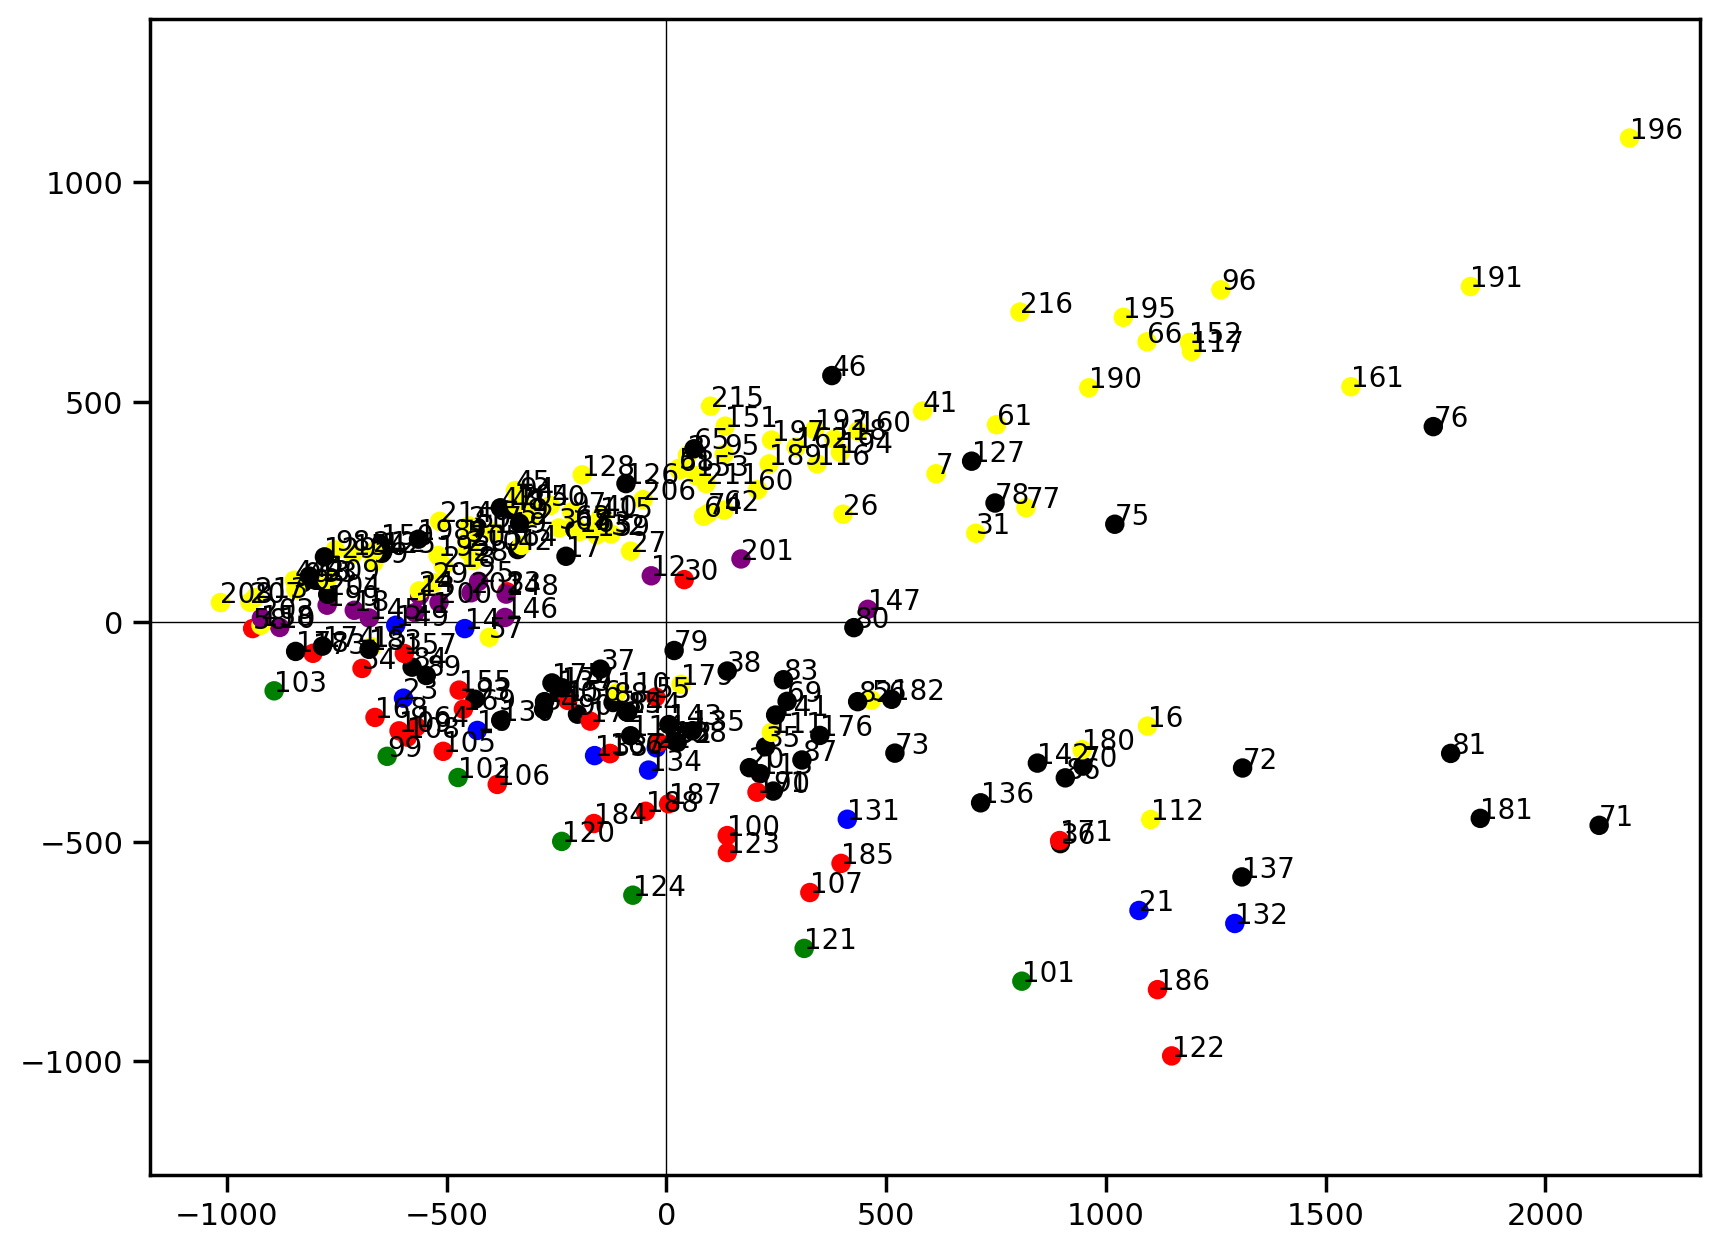

In [52]:
plot_embedding(X_[:,:2], c=clrs)
plt.savefig("img/pca_counts.png")

In this representation, longer pieces have much more influence in the dimensionality reduction simply because they contain more notes. In order to circumvent this issue, we can normalize the note counts in the corpus and only represent **relative frequencies** (aka percentages) of notes.

In [53]:
rel_note_counts = note_counts.div(note_counts.sum(axis=1), axis=0)
rel_note_counts.head()

,F-,C-,G-,D-,A-,E-,B-,F,C,G,...,A,E,B,F#,C#,G#,D#,A#,E#,B#
0,0.001117,0.001117,0.001117,0.001117,0.001117,0.001117,0.096089,0.092179,0.062570,0.284358,...,0.124581,0.054749,0.001117,0.007821,0.001117,0.001117,0.001117,0.001117,0.001117,0.001117
1,0.000436,0.000436,0.000436,0.000436,0.000436,0.002181,0.115569,0.131487,0.073703,0.221108,...,0.127780,0.059747,0.000654,0.008286,0.008504,0.000436,0.000436,0.000436,0.000436,0.000436
2,0.000297,0.000297,0.000297,0.000297,0.000297,0.008923,0.128792,0.146639,0.092802,0.171327,...,0.137418,0.058001,0.000297,0.006990,0.009816,0.000297,0.000297,0.000297,0.000297,0.000297
3,0.000409,0.000409,0.000409,0.000409,0.000409,0.000409,0.105274,0.116312,0.077065,0.224652,...,0.128373,0.084424,0.000409,0.006950,0.011038,0.000409,0.000409,0.000409,0.000409,0.000409
4,0.001114,0.001114,0.001114,0.001114,0.001114,0.001114,0.119154,0.108018,0.079065,0.221604,...,0.111359,0.065702,0.001114,0.007795,0.010022,0.001114,0.001114,0.001114,0.001114,0.001114


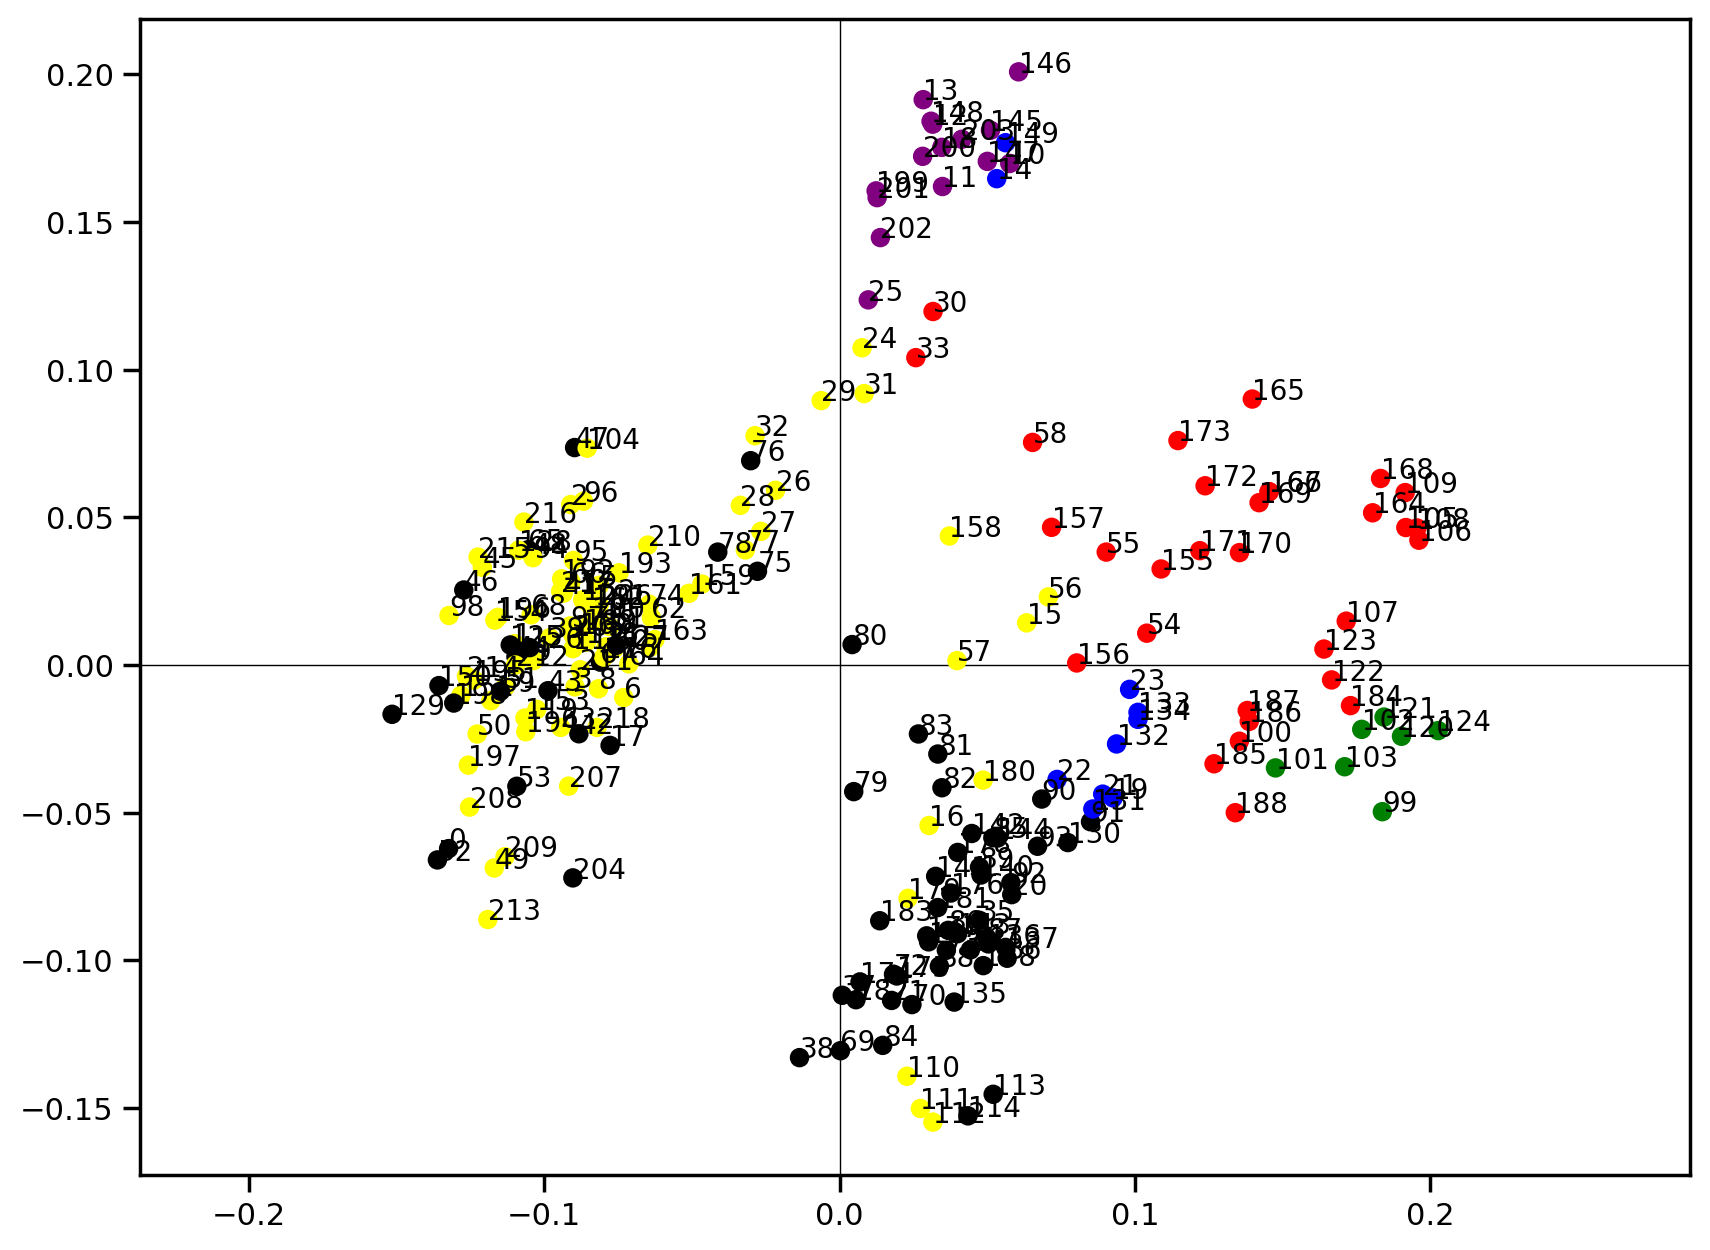

In [54]:
pca_reducer.fit(rel_note_counts.values)
X__ = pca_reducer.transform(rel_note_counts.values)
plot_embedding(X__[:,:2], c=clrs)
plt.savefig("img/pca_relcounts.png")

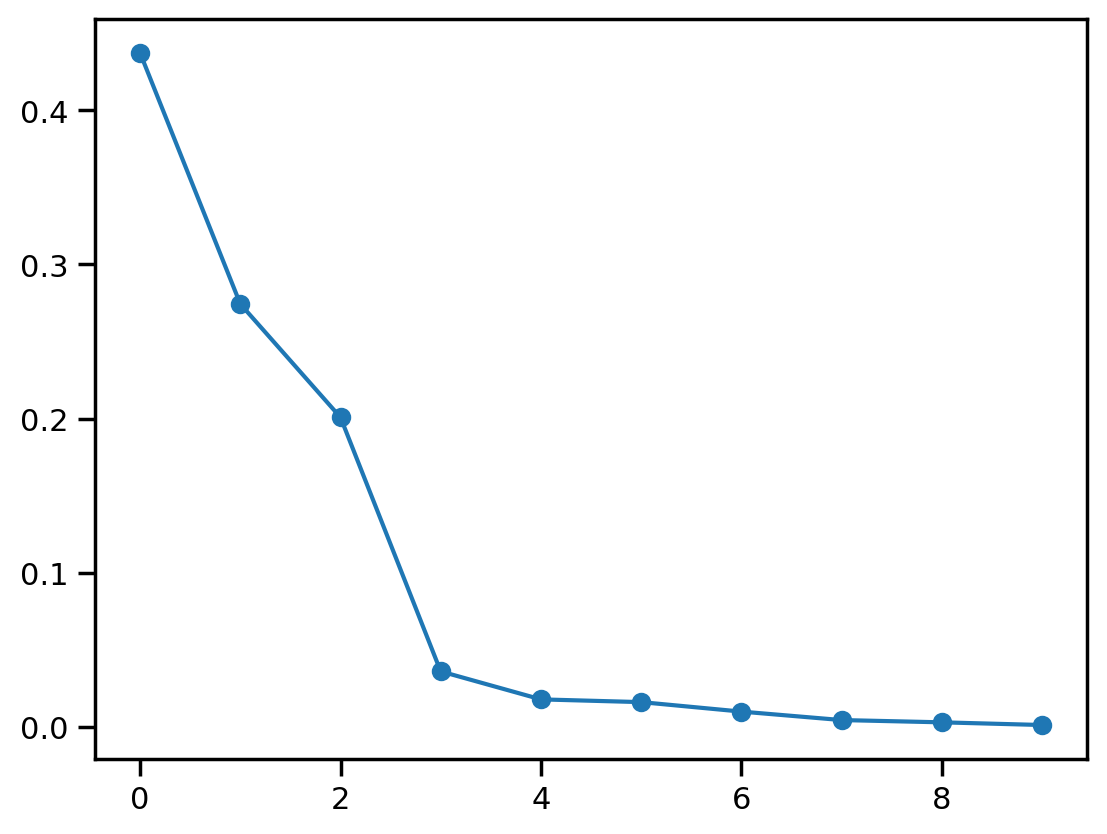

In [55]:
plt.plot(pca_reducer.explained_variance_ratio_[:10], marker="o");

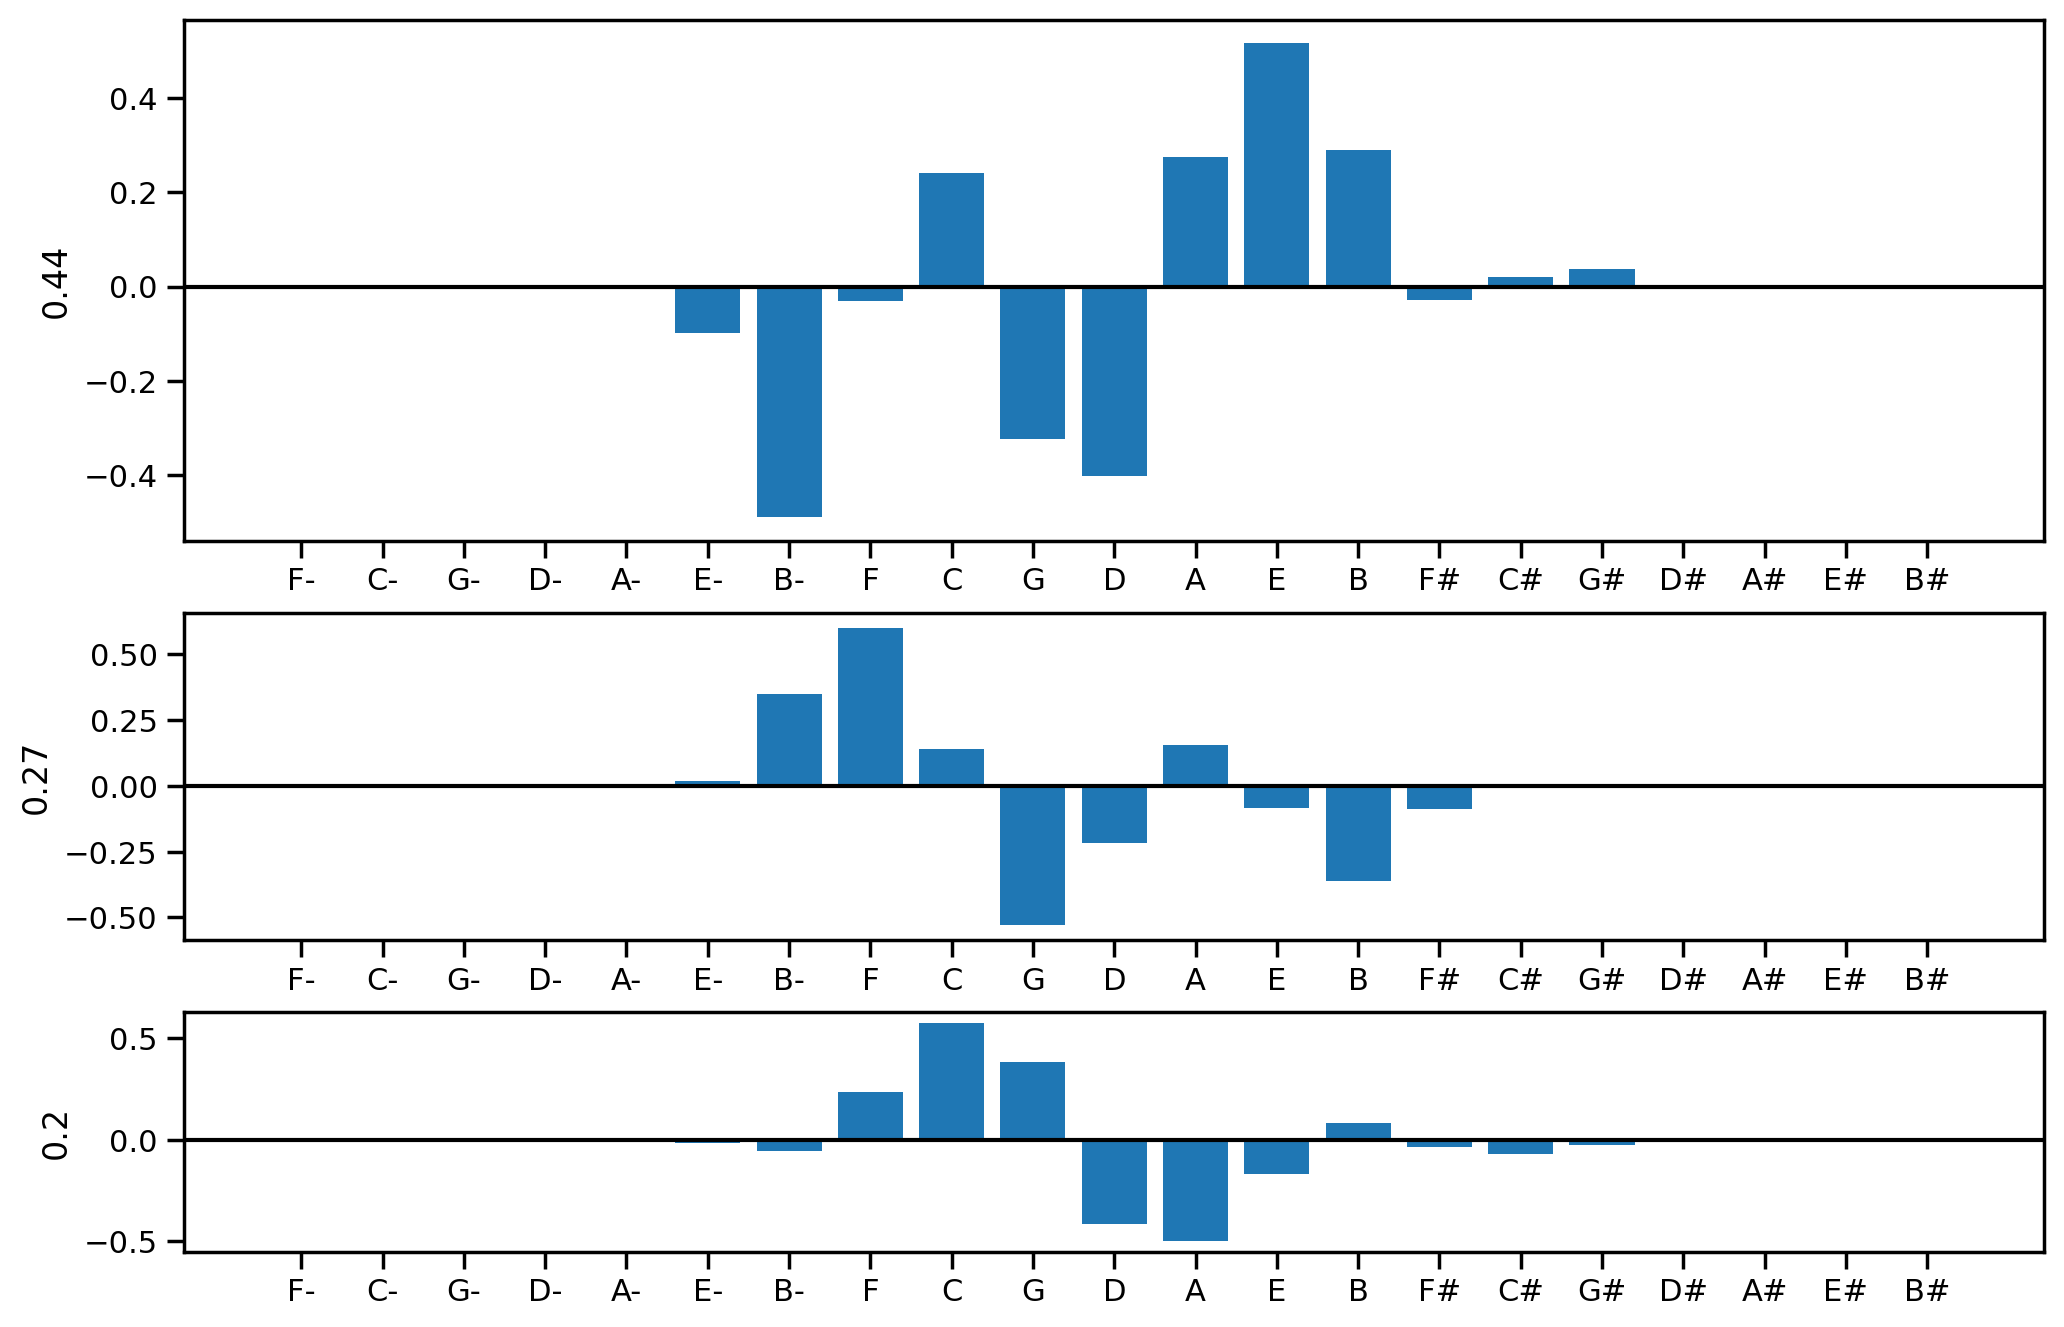

In [56]:
N = pca_reducer.components_.shape[0]
N = 3

fig, axes = plt.subplots(N,1, sharex=False, figsize=(12,8), gridspec_kw={'height_ratios': pca_reducer.explained_variance_ratio_[:N]})

for n in range(N):
    axes[n].axhline(0, c="black")
    axes[n].bar(range(len(lof)), pca_reducer.components_[n])
    axes[n].set_xticks(range(len(lof)), lof)
    
    var = pca_reducer.explained_variance_ratio_[n]
    axes[n].set_ylabel(round(var,2))
plt.show()

## 4 Finding clusters

In [57]:
K = 4

clusterer = KMeans(n_clusters=K)
clusterer.fit(X__)

KMeans(n_clusters=4)

In [58]:
cluster_clrs = np.array(clrs)[[ np.where(clusterer.labels_ == i)[0][2] for i in range(K) ]]
cluster_clrs

array(['red', 'yellow', 'black', 'purple'], dtype='<U6')

ValueError: too many values to unpack (expected 2)

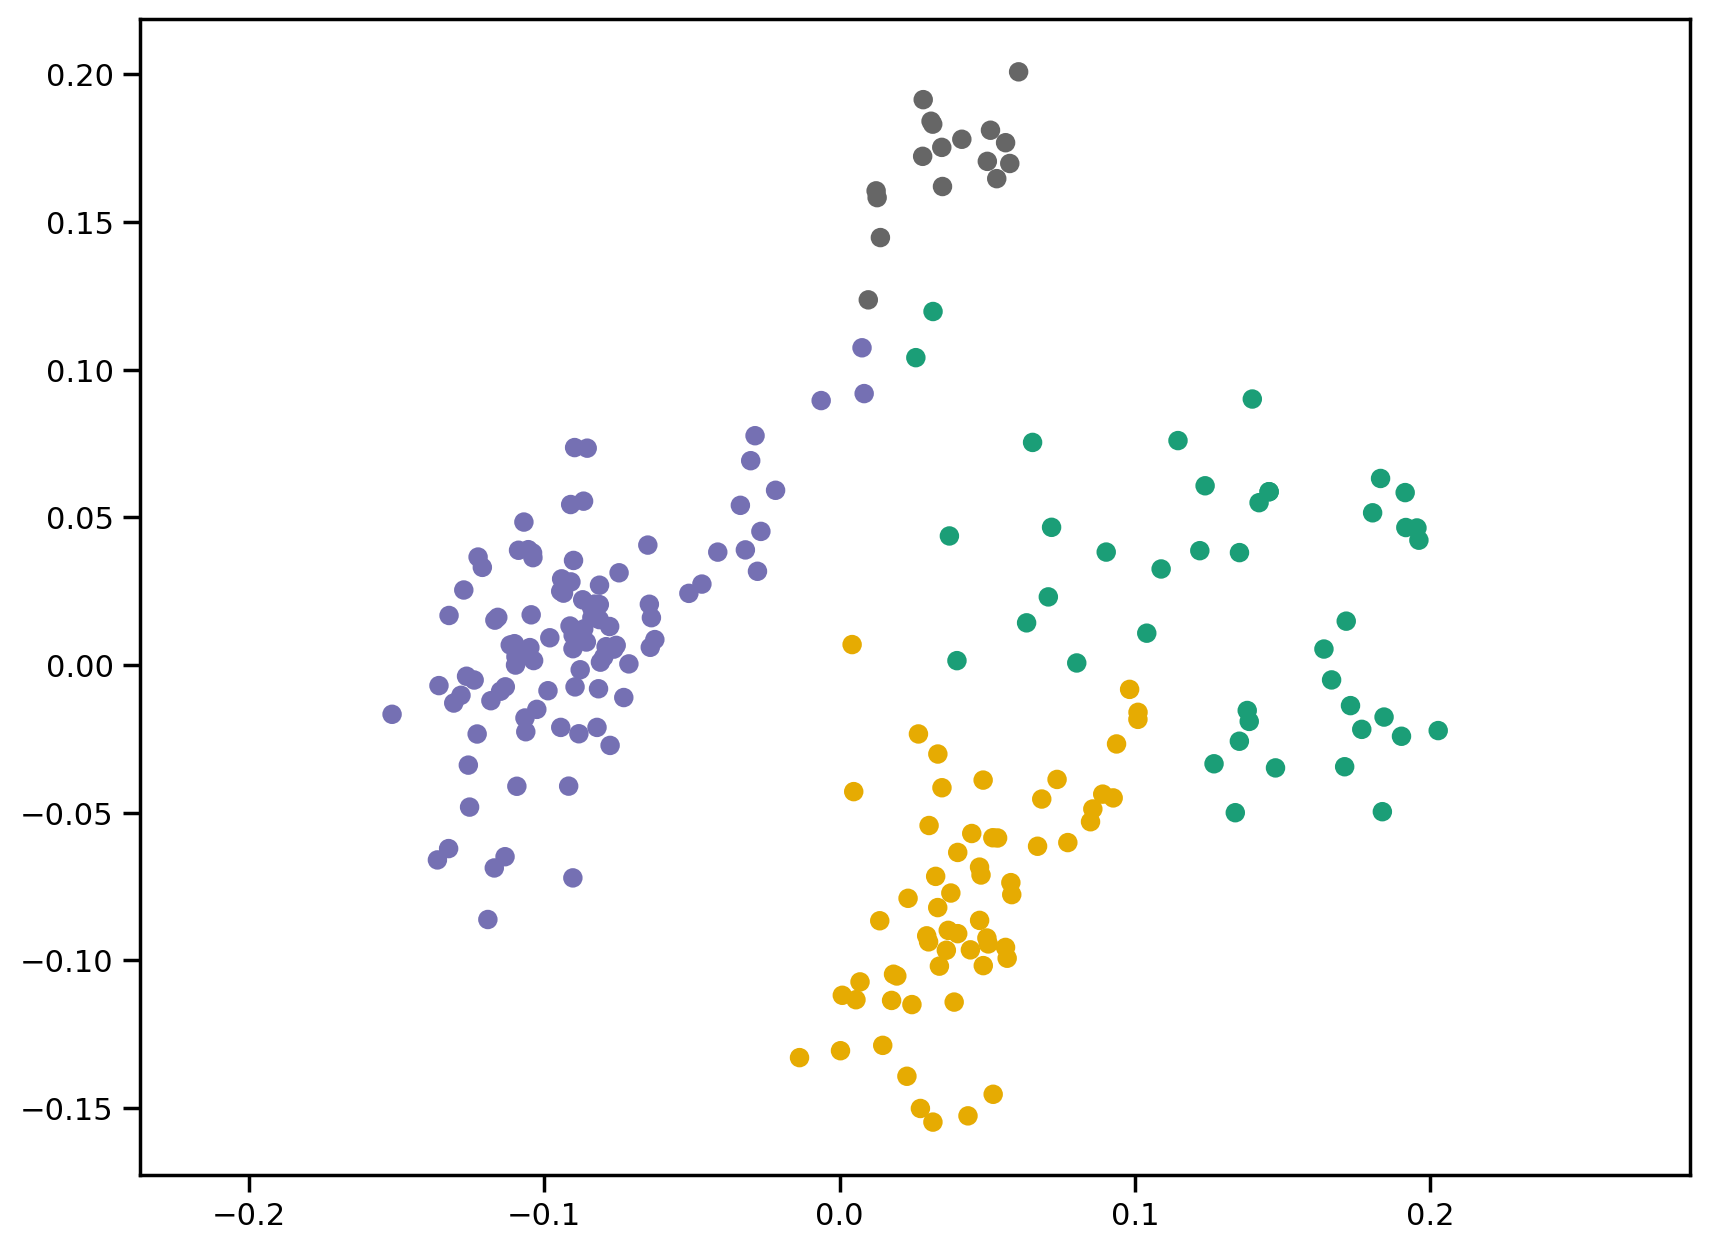

In [59]:
plot_embedding(X__, c=clusterer.labels_, cmap=cmap)

for i, ((x,y), c) in enumerate(zip(centers, clrs)): # cluster_clrs
    circ = Circle(
        xy=(x,y), 
        radius=.01, 
        edgecolor=c, 
        linewidth=2, 
        facecolor="white", 
        zorder=3
    )
    ax = plt.gca()
    ax.add_patch(circ)
    plt.text(x, y, f"C{i}", fontsize=12, va="center", ha="center", zorder=4)
plt.savefig("img/pca_relcounts_clusters.png")

Some observations: 
- The first principal component (PC1) separates cluster C2 (final G) from all other clusters.
- The second principal component (PC2) separates cluster C3 (final C) from all other clusters.

--> 

**Note distributions within clusters**

In [298]:
df = rel_note_counts
df["cluster"] = clusterer.labels_

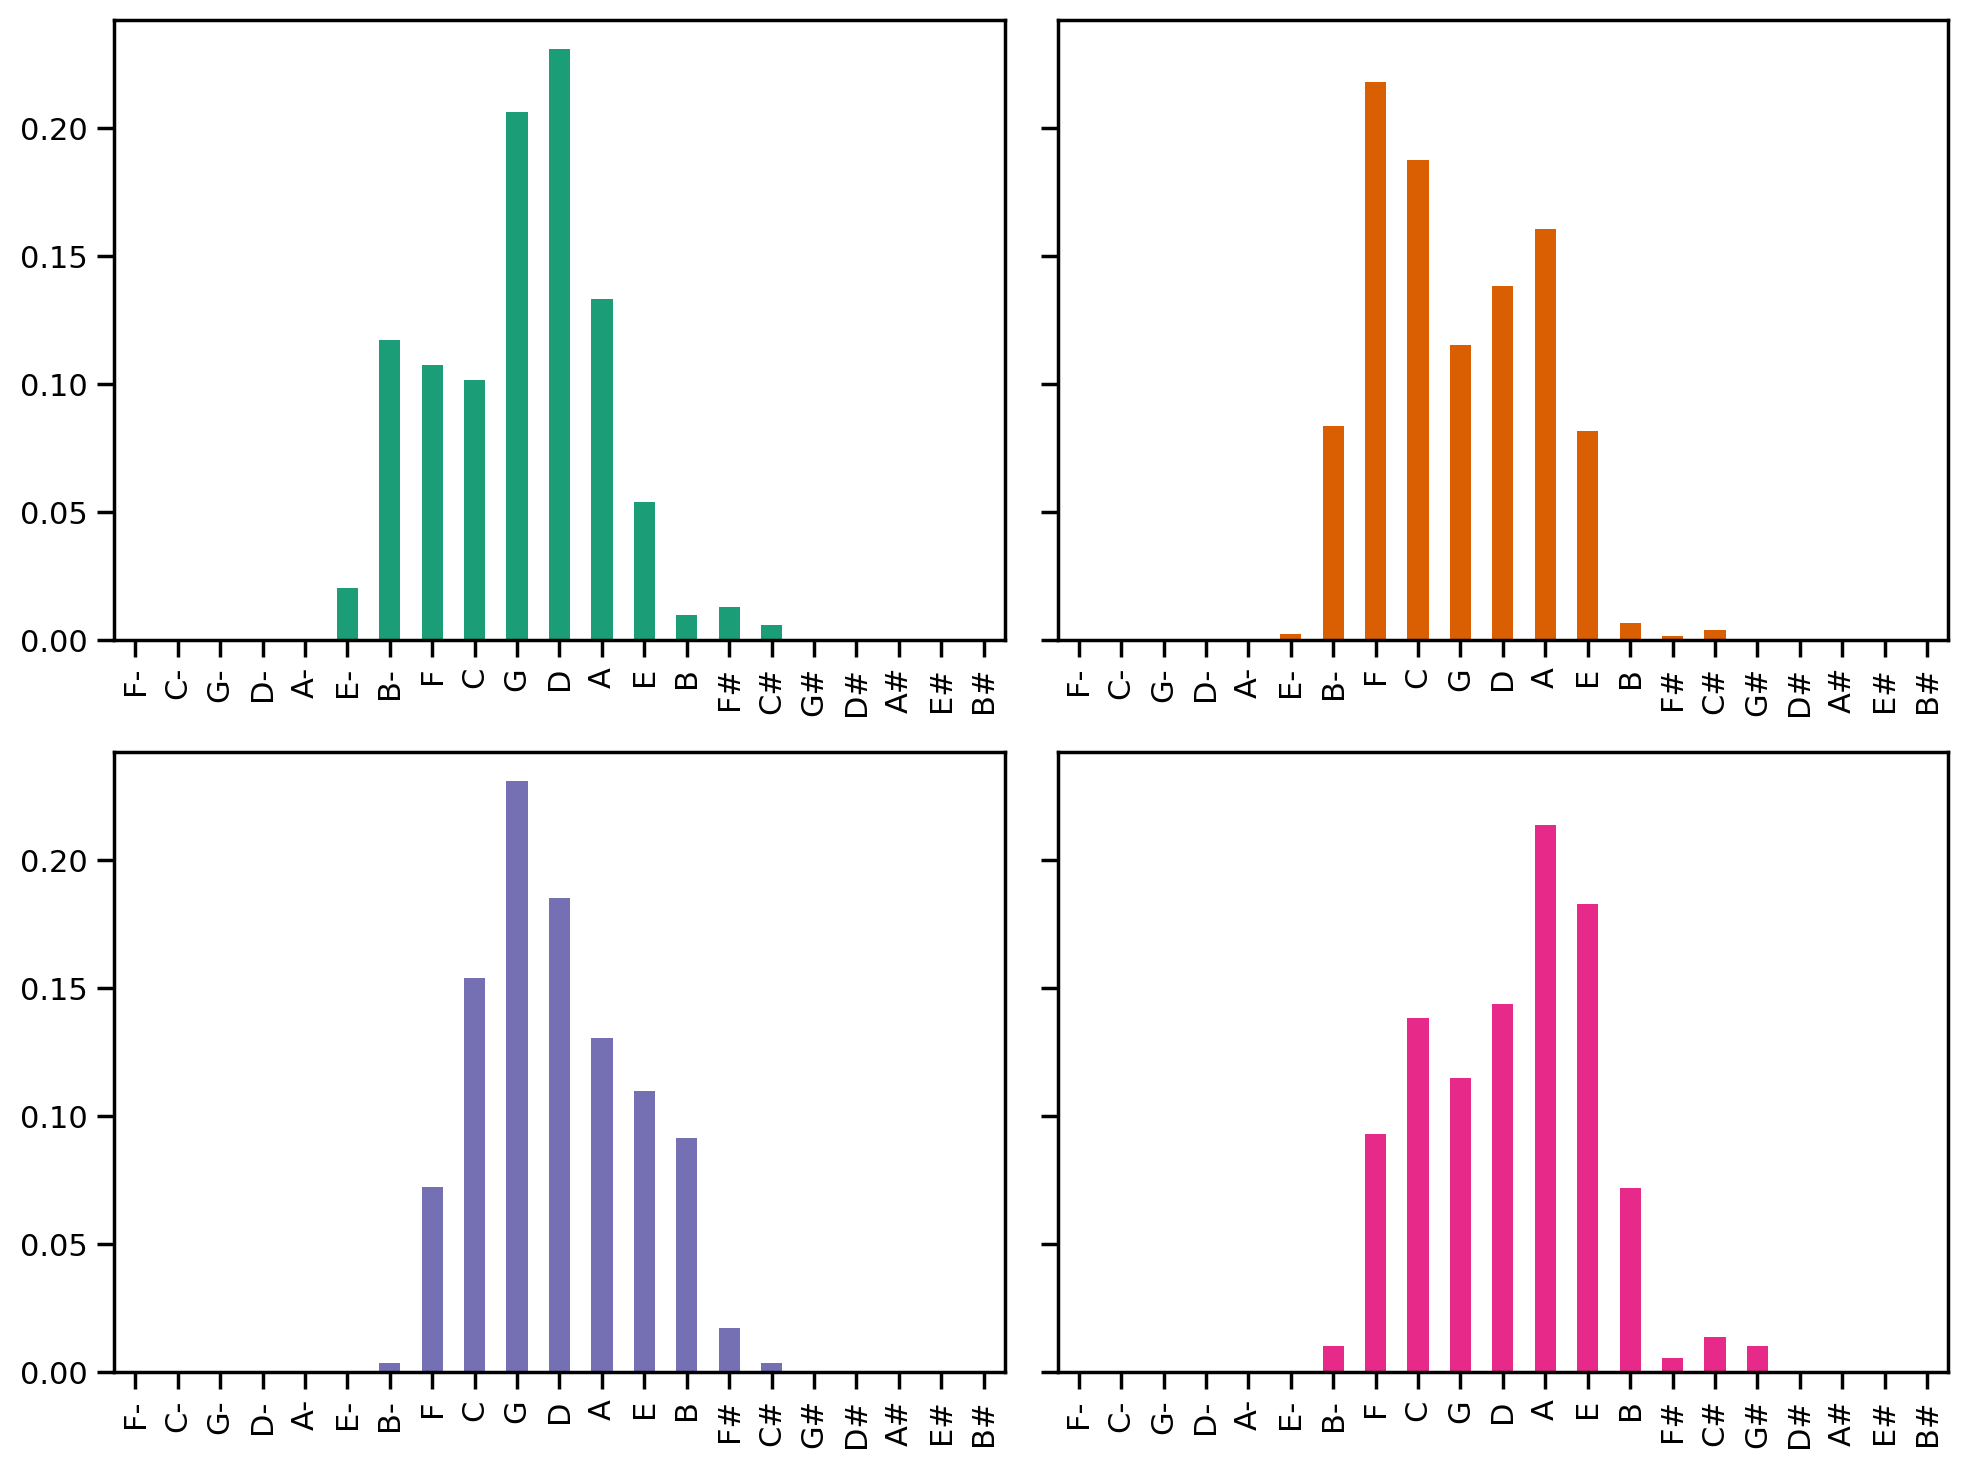

In [299]:
means = df.groupby("cluster").mean()

fig, axes = plt.subplots(2,2, figsize=figsize, sharey=True)
axes = axes.flatten()
for i, m in means.iterrows():
    m.plot(kind="bar", ax=axes[i], color=cmap(i)) # color=cluster_clrs[i], 
plt.tight_layout()
plt.savefig("img/cluster_dists.png")

## 5 Conclusion

## Rendering scores

In [35]:
def render_piece(path, start=None, end=None, options=None):
    # based on code provided by Richard Freedman
    
    tk = verovio.toolkit()
    tk.loadFile(path)

    options = {
        "breaks" : "auto"
    }
    
    if not (start == None) or (end == None):
        options["measureRange"] = f"{start}-{end}"

    # select verovio measures and redo layout
    tk.select(str(options))
    tk.setScale(40)
    tk.redoLayout()

    # get the number of pages and display the music
    count = tk.getPageCount()
    for c in range(1, count + 1):
        rendered = tk.renderToSVG(c)
        #print("File Name: ", piece.file_name)
        #print(piece.metadata['composer'])
        #print(piece.metadata['title'])
        display(HTML(rendered))

In [50]:
render_piece(local_files[10], start=3, end=5)

[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>


## Some observations

- D# -- B# ?!

In [51]:
note_counts.sum(axis=0).round(2)

F-         2.00
C-         0.00
G-         0.00
D-        42.00
A-        69.00
E-      6220.17
B-     42535.50
F      73554.67
C      93609.50
G     132128.08
D     135186.08
A     105802.92
E      69071.58
B      32199.17
F#      8009.50
C#      4359.00
G#      1487.00
D#         4.00
A#         2.00
E#         0.00
B#         9.00
dtype: float64

Apparently, there are 4 quartes of D#'s, 2 quarters of A#'s and even 9 quarters of B#'s. In which pieces can they be found?

In [52]:
odd_notes = note_counts[
    (note_counts["D#"] > 0) |\
    (note_counts["A#"] > 0) |\
    (note_counts["B#"] > 0)
]
odd_notes

,F-,C-,G-,D-,A-,E-,B-,F,C,G,...,A,E,B,F#,C#,G#,D#,A#,E#,B#
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,299.5,652.5,...,435.5,339.5,423.5,233.5,16.0,0.0,4.0,0.0,0.0,0.0
128,0.0,0.0,0.0,0.0,0.0,41.0,487.5,287.0,316.5,545.0,...,328.0,151.0,1.0,39.0,14.0,0.0,0.0,2.0,0.0,0.0
161,0.0,0.0,0.0,0.0,0.0,71.0,664.0,819.0,611.5,1177.0,...,1315.0,573.0,40.0,110.0,139.0,0.0,0.0,0.0,0.0,8.0
173,0.0,0.0,0.0,0.0,0.0,0.0,43.0,142.0,107.0,71.0,...,308.0,184.0,48.0,5.0,39.0,10.0,0.0,0.0,0.0,1.0


In [53]:
odd_notes.index.values

array([114, 128, 161, 173])

In [54]:
odd_files = np.array(local_files)[odd_notes.index.values]
odd_files

array(['data/CRIM_Mass_0024_5.mei', 'data/CRIM_Mass_0027_4.mei',
       'data/CRIM_Mass_0036_3.mei', 'data/CRIM_Mass_0039_5.mei'],
      dtype='<U25')

In [55]:
for i, n in enumerate(m21.converter.parse(odd_files[-1]).flatten().notes):
    if "#" in n.name:
        print(n)

NameError: name 'm21' is not defined

--> There is no B#, so how could it have ended up in the df?

In [312]:
o = "/home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0039_5.mei"

In [313]:
for i, n in enumerate(m21.converter.parse(o).flatten().notes):
    if "#" in n.name:
        print(n)

<music21.note.Note C#>
<music21.note.Note C#>
<music21.note.Note C#>
<music21.note.Note G#>
<music21.note.Note G#>
<music21.note.Note C#>
<music21.note.Note C#>
<music21.note.Note F#>
<music21.note.Note G#>
<music21.note.Note C#>
<music21.note.Note C#>


### A "neutral" piece?

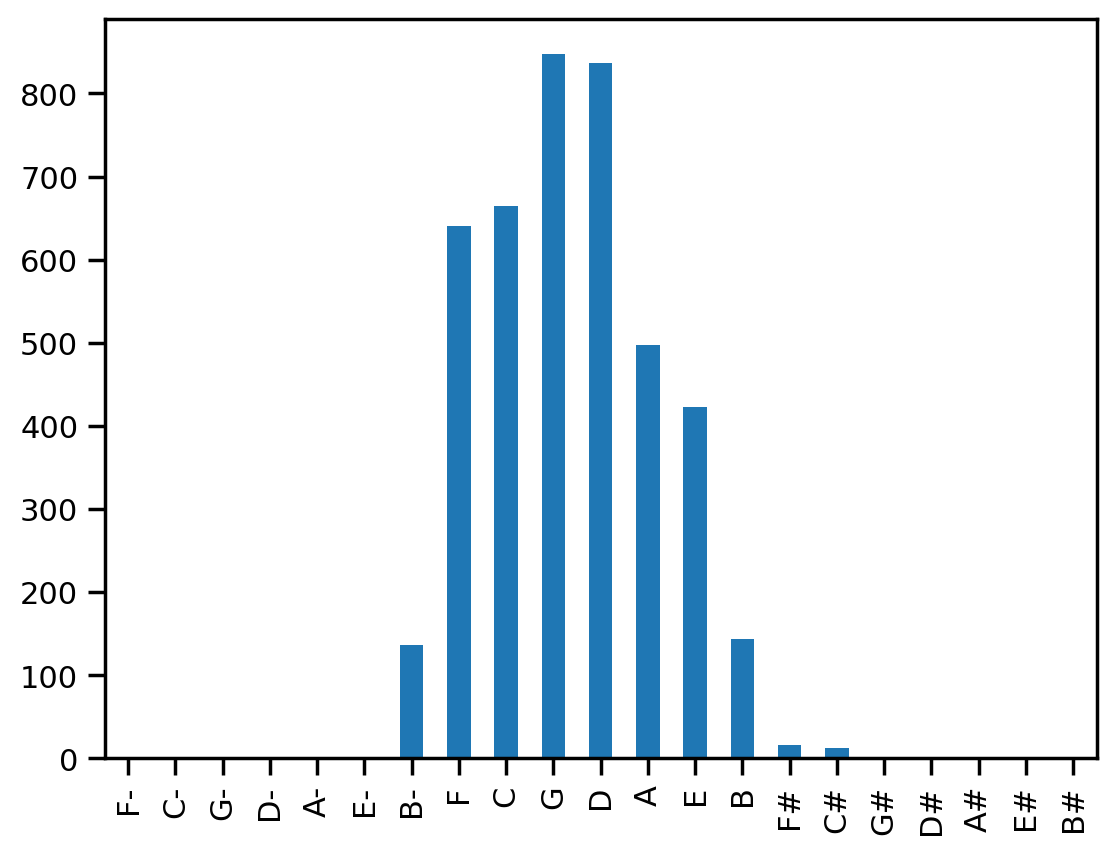

In [302]:
note_counts.iloc[80,:].plot(kind="bar");

In [57]:
render_piece(local_files[80])

[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Selection 'measureRange' could not be parsed. No selection set.


Missa Baisiez moy: Credo, by Mathurin Forestier

**Values of finals don't all make sense**

In [43]:
finals[102]

'Res'

In [41]:
render_piece(local_files[102], start=53, end=56)

[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '90'
[Warning] Skipping nodes after <score> element


## Conclusion: on style

Meyer quote

## References

- Jurafsky, D. & Martin, J. H. (2014). _Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition_ (2nd ed.). Pearson.
- Kastorp, F., Kestemont, M., & Riddell, A. (2022). _Humanities Data Analysis: Case Studies with Python_. Princeton University Press. https://www.humanitiesdataanalysis.org/vector-space-model/notebook.html
- Meyer, L. B. (1989). _Music and Styles: Theory, History, and Ideology_. Chicago University Press.

In [225]:
corpus.scores[4].metadata["composer"]

{'title': 'Missa Confitemini: Agnus Dei', 'composer': 'Pierre Colin'}

In [189]:
corpus.scores[3]

CTB   CB    CT   TC  TCB  CuTx  CuTB  CTx  CxTB  Cxx  ...  CtBB  \
Measure Beat                                                        ...         
1       1.0   4.0  3.0   3.0  3.0  2.0   1.0   1.0  1.0   1.0  1.0  ...   1.0   
        1.0   4.0  2.0   6.0  1.0  4.0   3.0   3.0  3.0   2.0  2.0  ...   1.0   
        1.0   9.0  1.0  10.0  3.0  1.0   1.0   6.0  3.0   3.0  1.0  ...   1.0   
        2.5   6.0  6.0  13.0  1.0  2.0   1.0   3.0  4.0   1.0  1.0  ...   1.0   
        3.0   3.0  1.0   5.0  1.0  2.0   2.0   1.0  2.0   2.0  1.0  ...   1.0   
...           ...  ...   ...  ...  ...   ...   ...  ...   ...  ...  ...   ...   
27      4.0   4.0  4.0   2.0  1.0  3.0   1.0   2.0  1.0   1.0  1.0  ...   1.0   
        4.5   6.0  4.0   6.0  1.0  5.0   1.0   1.0  3.0   1.0  1.0  ...   1.0   
28      1.0   7.0  8.0  10.0  1.0  3.0   1.0   1.0  1.0   1.0  1.0  ...   1.0   
        1.5   5.0  2.0   2.0  2.0  1.0   1.0   1.0  1.0   1.0  1.0  ...   1.0   
        2.0   4.0  2.0   6.0  1.0  2.0   1.0   1.0  2.0   1.0  1.0  ...   1.0   

              CTux  tCQT  zCQT  CuQ  CTtB  zCuBT  CQx  CTt  zCBx  
Measure Beat                                                      
1       1.0    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   1.0  
        1.0    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   1.0  
        1.0    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   1.0  
        2.5    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   1.0  
        3.0    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   1.0  
...            ...   ...   ...  ...   ...    ...  ...  ...   ...  
27      4.0    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   1.0  
        4.5    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   1.0  
28      1.0    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   2.0  
        1.5    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   1.0  
        2.0    1.0   1.0   1.0  1.0   1.0    1.0  1.0  1.0   1.0  

[219 rows x 221 columns]

In [188]:
corpus.scores[0].cadences()["CVFs"].value_counts()

CTB    3
CB     2
CT     2
TC     2
TCB    1
Name: CVFs, dtype: int64

In [62]:
corpus.scores[138]# .cadences()# ["CVFs"].value_counts()

-------

In [243]:
def get_counts(score):
    try: 
        return score.cadences()["CVFs"].value_counts()
    except Exception as e:
        print(e)

In [244]:
cvf_counts = []

for s in tqdm(corpus.scores):
    try:
        counts = get_counts(s)
        counts.name = s.metadata["composer"]
        cvf_counts.append(counts)
    except Exception as e:
        print(e)
        pass

# cvf_counts = [get_counts(s) for s in tqdm(corpus.scores)]




  0%|                                                   | 0/219 [00:00<?, ?it/s]


 40%|████████████████▍                        | 88/219 [00:00<00:00, 878.59it/s]


100%|████████████████████████████████████████| 219/219 [00:00<00:00, 725.22it/s]

asof requires a sorted index
'NoneType' object has no attribute 'name'
asof requires a sorted index
'NoneType' object has no attribute 'name'
asof requires a sorted index
'NoneType' object has no attribute 'name'


In [245]:
cvf_counts[:2]

[CTB    3
 CB     2
 CT     2
 TC     2
 TCB    1
 Name: Pierre Colin, dtype: int64,
 CT      5
 TCB     3
 CTB     3
 CuTx    2
 CuTB    2
 CTx     2
 CxTB    1
 Cxx     1
 zC      1
 tCB     1
 CB      1
 Name: Pierre Colin, dtype: int64]

In [462]:
df = pd.DataFrame(cvf_counts).reset_index(drop=False).fillna(0)

from sklearn.feature_extraction.text import TfidfTransformer
df.head()

,index,CTB,CB,CT,TC,TCB,CuTx,CuTB,CTx,CxTB,...,CtBB,CTux,tCQT,zCQT,CuQ,CTtB,zCuBT,CQx,CTt,zCBx
0,Pierre Colin,3.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Pierre Colin,3.0,1.0,5.0,0.0,3.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Pierre Colin,8.0,0.0,9.0,2.0,0.0,0.0,5.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Pierre Colin,5.0,5.0,12.0,0.0,1.0,0.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Pierre Colin,2.0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [463]:
tfidf = TfidfTransformer(sublinear_tf=True)
Y = tfidf.fit_transform(df.iloc[:,1:].values)
Y

<216x221 sparse matrix of type '<class 'numpy.float64'>'
	with 2666 stored elements in Compressed Sparse Row format>

In [466]:
# from sklearn.decomposition import FastICA, PCA
# from sklearn.manifold import MDS

# X = MDS(n_components=2).fit_transform(df.values) + .5

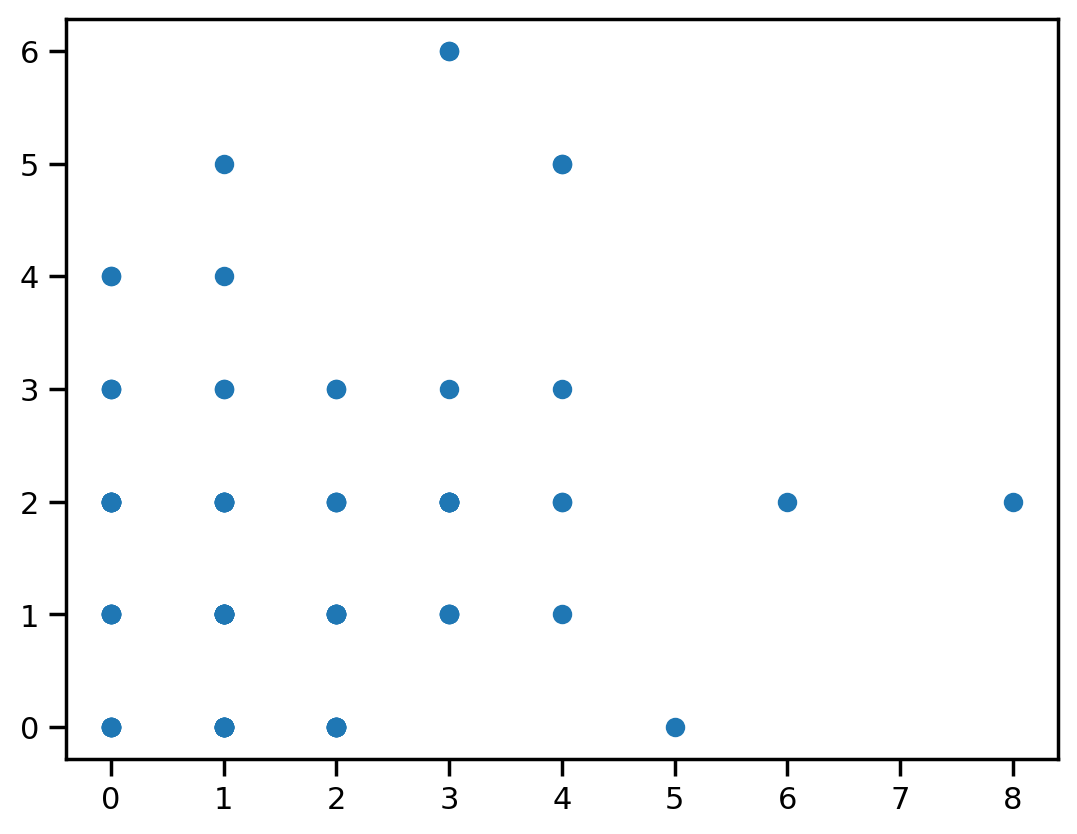

In [467]:
_, ax = plt.subplots()
ax.axis("equal")
ax.scatter(X[:,0], X[:,1])
plt.show()

In [468]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [469]:
X, y = df.iloc[:,1:].values, df["index"].values

In [470]:
y_test

array(['Francisco Guerrero', 'Annibale Padovano', 'Francisco Guerrero',
       'Francisco Guerrero', 'Francisco Guerrero', 'Roland de Lassus',
       'Annibale Padovano', 'Roland de Lassus', 'Francisco Guerrero',
       'Giovanni Pierluigi da Palestrina', 'Claudin de Sermisy',
       'Giovanni Pierluigi da Palestrina', 'Annibale Padovano',
       'Francisco Guerrero', 'Francisco Guerrero',
       'Giovanni Pierluigi da Palestrina', 'Annibale Padovano',
       'Claudin de Sermisy', 'Roland de Lassus', 'Annibale Padovano'],
      dtype=object)

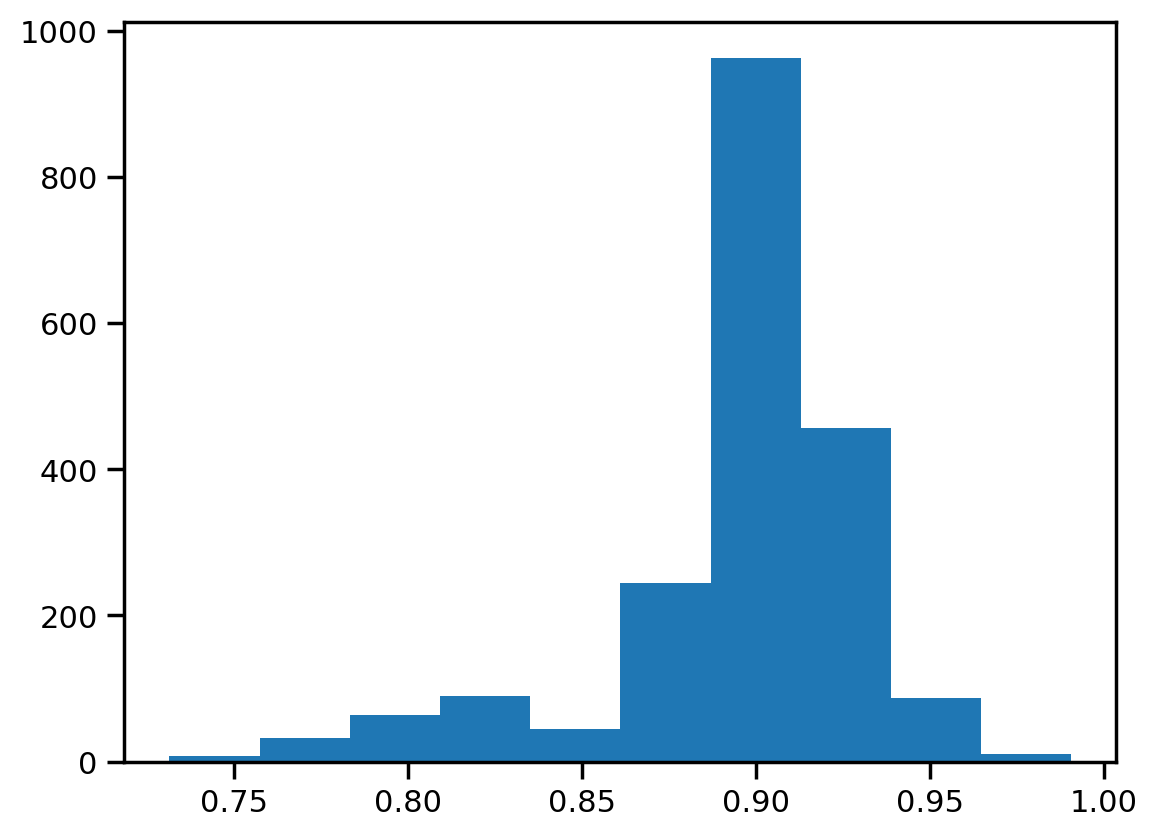

In [471]:
_, ax = plt.subplots()

scorings = []
for _ in range(2000):
    X_train, X_test, y_train, y_test = train_test_split(Y, y, train_size=.5, shuffle=True)
    mnb = MultinomialNB(alpha=50)
    y_pred = mnb.fit(X_train, y_train).predict(X_test)
    scorings.append(sum(y_test != y_pred) / len(y_pred))
ax.hist(scorings)
plt.show()

In [472]:
from sklearn.metrics import confusion_matrix

In [473]:
import seaborn as sns

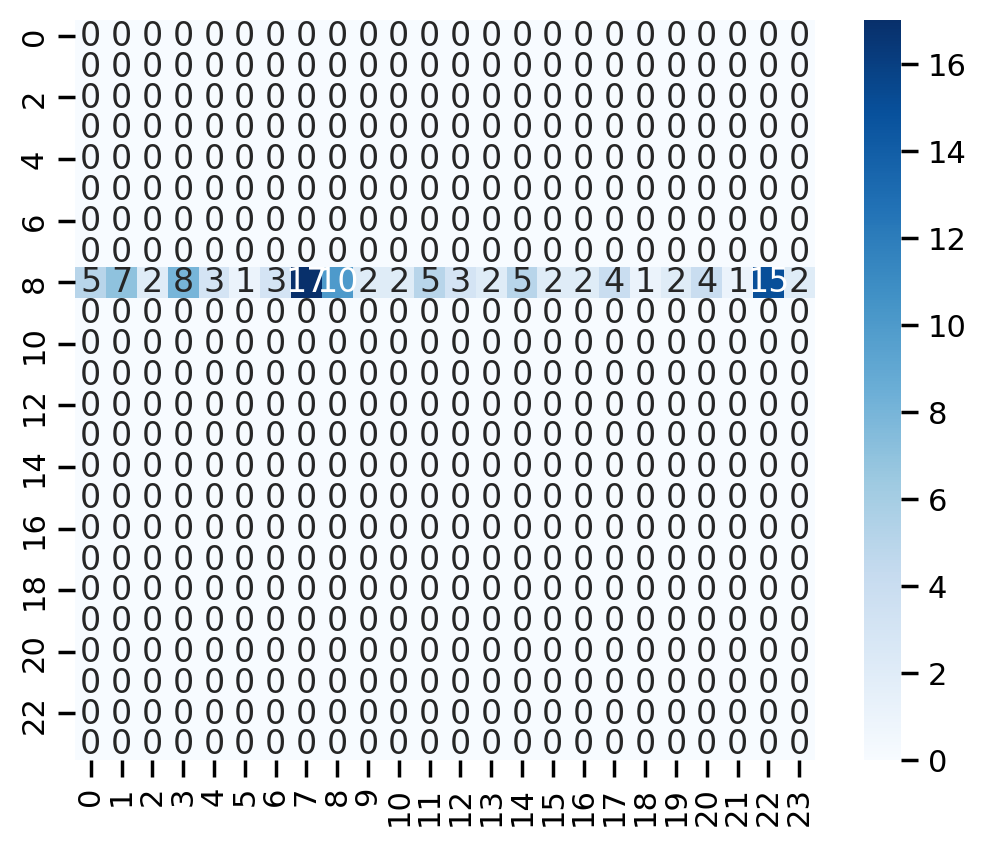

In [474]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, cmap="Blues");

In [475]:
df["index"].value_counts()

Giovanni Pierluigi da Palestrina    25
Roland de Lassus                    25
Francisco Guerrero                  20
Claudin de Sermisy                  15
Annibale Padovano                   15
Antoine de Févin                    10
Nicole des Celliers de Hesdin        9
Nicolas Gombert                      5
Pierre de Manchicourt                5
Adrian Willaert                      5
Cipriano de Rore                     5
Mathurin Forestier                   5
Pierre Colin                         5
Jean Guyon                           5
Jean Hérissant                       5
Cristóbal de Morales                 5
Pierre Daulphin                      5
Loyset Pieton                        5
Claudio Merulo                       5
Ippolito Baccusi                     5
Nicolas De Marle                     5
Dominique Phinot                     5
Pere Riquet                          5
Mathieu Sohier                       5
Tomás Luis de Victoria               5
Pierre Clereau           

In [482]:
df2 = df.groupby("index").filter(lambda x: len(x) > 5)

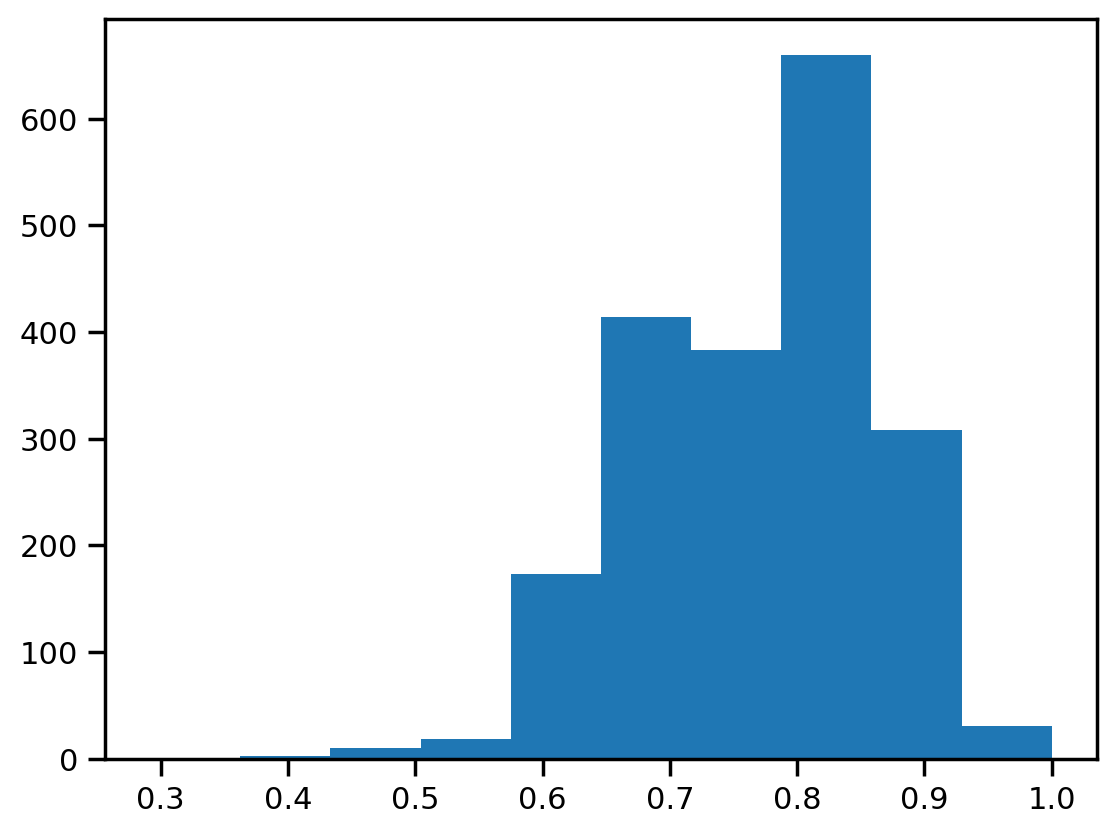

In [483]:
X, y = df2.iloc[:,1:].values, df2["index"].values

_, ax = plt.subplots()

scorings = []
for _ in range(2000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True)
    mnb = MultinomialNB(alpha=50)
    y_pred = mnb.fit(X_train, y_train).predict(X_test)
    scorings.append(sum(y_test != y_pred) / len(y_pred))
ax.hist(scorings)
plt.show()

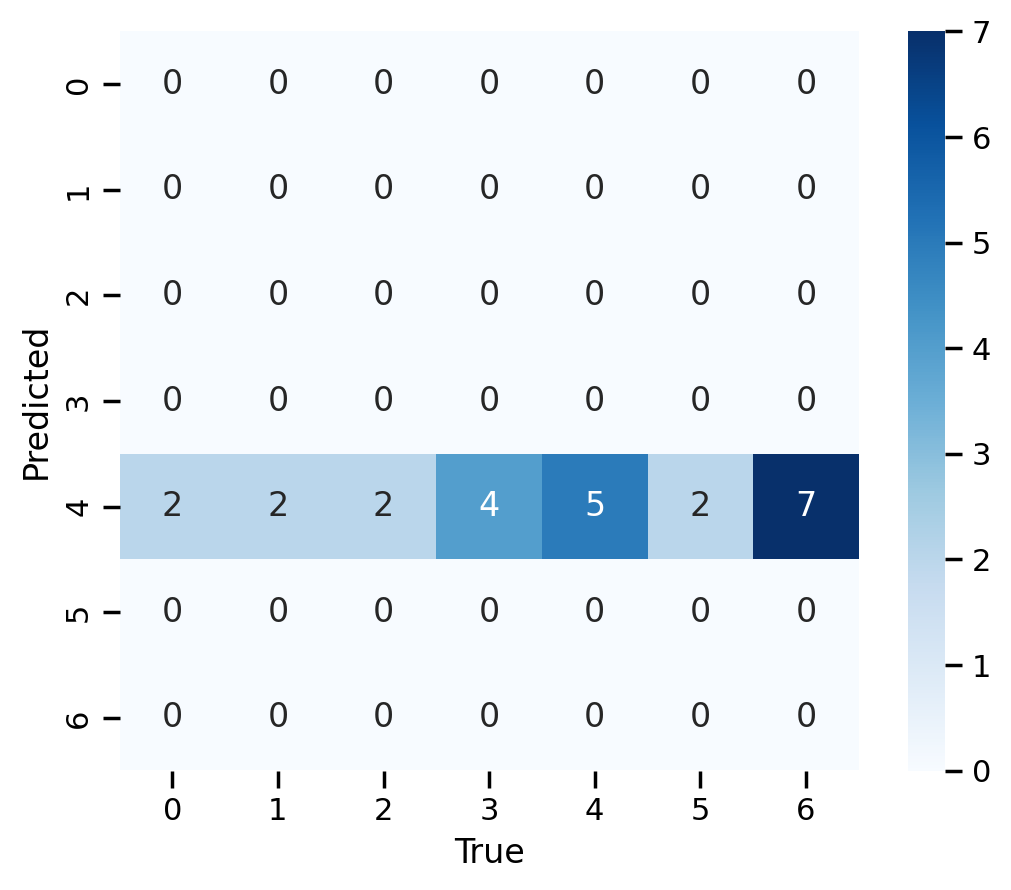

In [484]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, cmap="Blues")
plt.xlabel("True")
plt.ylabel("Predicted");

## The vector-space model

**In the _vector-space model_, counts of terms are represented in a high-dimensional abstract space. Imagine that terms are stored in a vocabulary with $V$ entries, then the (relative) frequency of these terms in a document (here: in a mass movement) is represented by a real number.**

### $n$-gram models

The concept of $n$-grams is useful to describe sequences of different lengths. 

It comes from the field of _Formal Language Theory_ (FLT). Imagine we have two sequences (e.g., melodies), 
$$s_1 = n_1 n_2 \ldots n_k$$
and 
$$s_2 = n_1 n_2 \ldots n_l,$$
and both melodies are taken from a corpus within the same style. We can then as questions like, which melody is more likely (= more frequent)? 

$$P(s_1) \geq P(s_2).$$

Moreover, this model $n$-gram models let us ask questions like "Given a particular sequence (melody) $s=n_1\ldots n_t$, what is the most likely next note?:"

$$P(n_{t+1}| n_1 \ldots n_t)$$

In the above expression, the probability of the note $n_{t+1}$ depends on the entire "history" of the previous notes in the melody. For a handful of notes, this is not a problem, but it can become difficult to calculate when sequences get very long. This is where the so-called _Markov assumption_ enters the stage:

$$P(n_{t+1}| n_1 \ldots n_t) \approx P(n_{t+1}| n_t).$$

It states that the probability of the next note in the melody, $n_{t+1}$, given the entire previous melody $n_1 \ldots n_t$ can be **approximated** by just looking at the probability of the next note $n_{t+1}$ given the last note $n_t$. We approximate entire melodies by only looking at pairs of notes! These are called **bigrams**. While this seems to be a drastic reduction of complexity (and it is!), it does work quite well in practice.

The $n$ in $n$-gram model determines the length of the history taken into account:
- **unigrams** ($n=1$) take a history of length 0 into account (these are just the raw frequencies of occurrence)
- **bigrams** ($n=2$) take a history of one note into account
- **trigrams** ($n=3$) take a history of two notes into account
- etc.